In [1]:
import numpy as np
import nolds
from matplotlib import pyplot as plt
from numpy import linalg as la
import os
from scipy import stats
from scipy import spatial as sp
from scipy import sparse
from sklearn import linear_model
from scipy import linalg as sla

import lyapynov as le

import pandas as pd
import networkx as nx

import SystemsSolved as s
import Methods as m

import Sparse_Reservoir_Computing as rc

import RecurrencePlotsCode as rp

In [2]:
#Getting time series
Ry = s.yCoupledRossler(a = 0.2, b = 0.2, c = 5.7, nu1 = 0.00, mu1 = 0, nu2 = 0.00, mu2 = 0)
Ry_ts = Ry.solve(t0 = 0, tFinal = 1000, x0_1 = [-1.5, 1.5, 20], x0_2 = [-5, -5, -5], dt = 0.01)

In [ ]:
#Setting indices 
tStart = 400
tEnd = 800
dt = 0.01
iStart = int(tStart/dt) #Discarding beginning of time series 
iEnd = int(tEnd/dt) 

#Splits ts and removes transient time 
A0 = Ry_ts[0:3, :] 
#B0 = Ry_ts[3:6, :] 



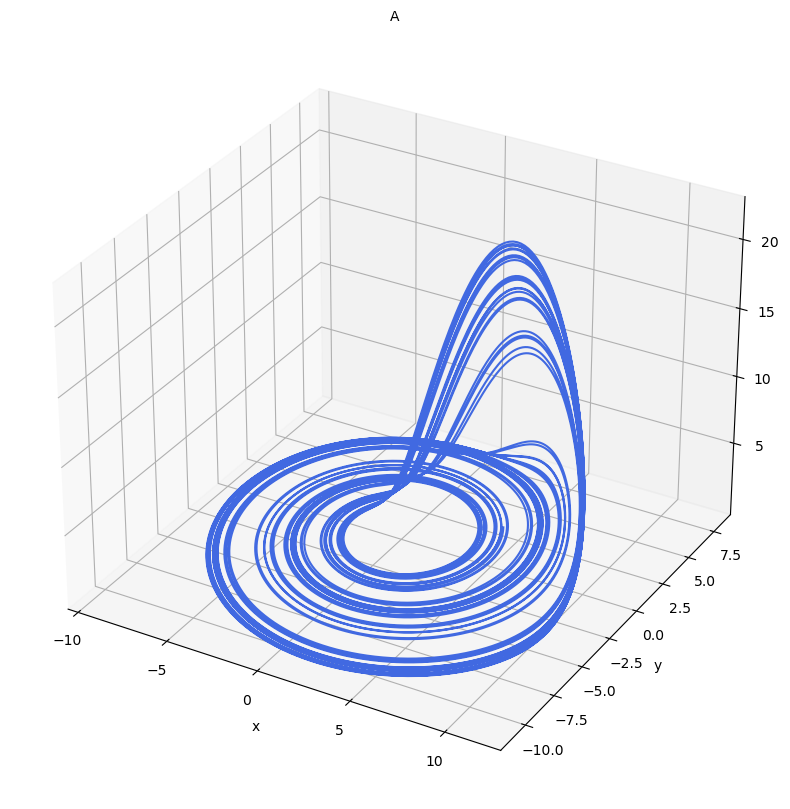

In [7]:
#Plot Two Time Series
p = m.plot3D(cols=1, rows=1)
p.plot3D(A0[:, iStart:iEnd], plotNum = 1, title = "A")
#p.plot3D(B0[:, iStart:iEnd], plotNum = 2, title = "B")

In [5]:
#Setting up Reservoir 

#Parameters
sigma = 0.42777 #Drive
rho = 0.01 #Spectral Radius

r = rc.Reservoir(Nodes = 100, InDim=3, seed=12)
r.Weighted_Erdos_R(SpecRadius=rho, p=0.04)
r.set_rdot(sigma = sigma, gamma = 1)
r.Set_W_in_Matrix() #Error from normalising specral radius

rc1 = rc.RC(SparseReservoir=r, U=A0, dt = 0.01)

rc1.Listening(time=700)
rc1.Training(t0 = 500, tEnd = 700)

c:\Users\jackr\anaconda3\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[1.5179179e-05]
not reaching the requested tolerance 1.4901161193847656e-06.
Use iteration 21 instead with accuracy 
1.5179179046911312e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
c:\Users\jackr\anaconda3\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.5179179e-05]
not reaching the requested tolerance 1.4901161193847656e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


In [6]:
rc1.Predicting(t0 = 700, tFinal = 1700)

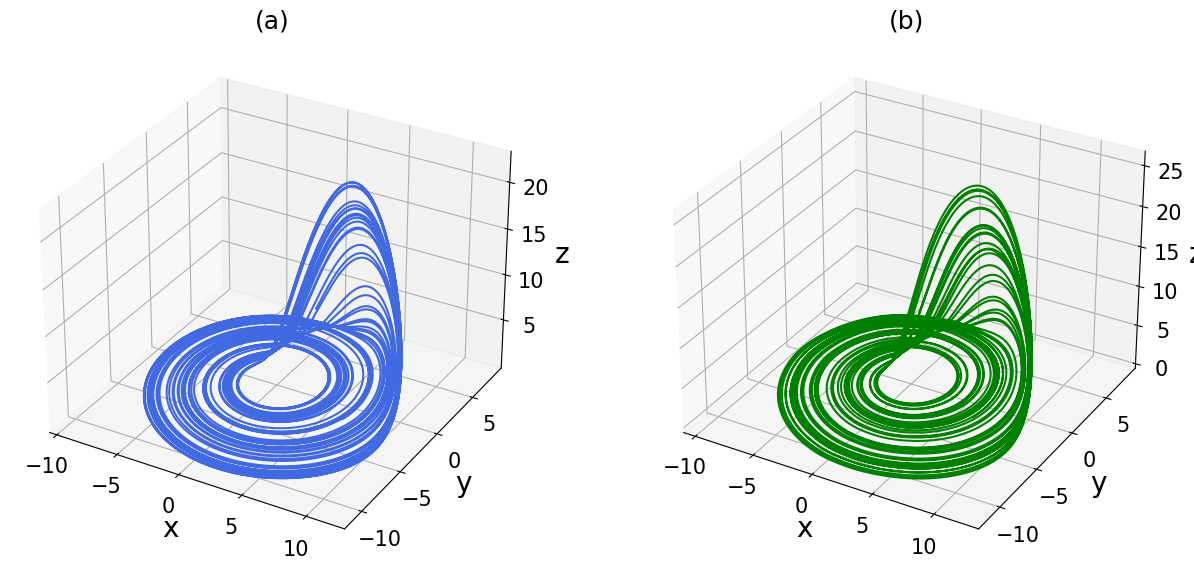

In [20]:
p1 = m.plot3D(cols=2, rows=2, figsize=(15, 15))

p1.plot3D(A0[:, 70000:100000], plotNum=1, title = "(a)", title_font_size=18, tick_label_size=15, axes_fontsize=[20, 20, 20])

p1.plot3D(rc1.uPrediction[:, 0:30000], plotNum=2, title = "(b)", title_font_size=18, tick_label_size=15, axes_fontsize=[20, 20, 20])


plt.savefig("OutputGraphics\\First_ReservoirReconstruction.svg")


In [23]:
from statsmodels.tsa.stattools import acf

In [ ]:
nlags = 20000; dt = 0.01
Time = int(nlags*dt)
time1 = np.linspace(0, Time, nlags)


acf_A0 = acf(A0[0, :], nlags= nlags)
acf_RC_A0 = acf(rc1.uPrediction[0, :], nlags = nlags)

In [34]:
acf_A0.shape

(20001,)

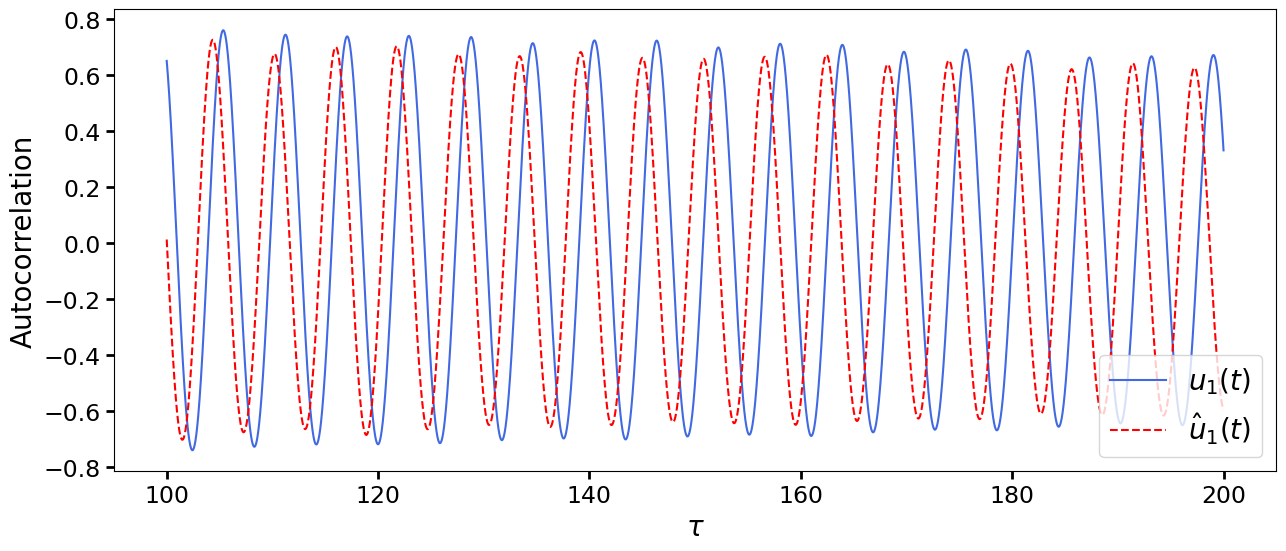

In [52]:
p = m.plot3D(cols =1, rows = 1, figsize=(15, 6))
p.plot2D(time1[10000:], acf_A0[10001:], plotNum=1, axlab=[r'$\tau$', "Autocorrelation"], tick_label_size=17, title="", axes_fontsize=[20, 20], label=r'$u_{1} (t)$')
plt.plot(time1[10000:], acf_RC_A0[10001:], color='r', label=r'$\hat u_{1} (t)$', linestyle='--')
#.plot2D(time1, acf_RC_A0[1:], plotNum=2, title = "Autocorrelation for "+ r'$\hat u(t)$' +" over "+r'$\tau$', axlab=[r'$\tau$', "Autocorrelation"], tick_label_size=10)
plt.legend(fontsize=20, loc='lower right')
plt.savefig("OutputGraphics\\Autocorrelation_RC.svg")

In [58]:
print(np.mean(rc1.uPrediction[0, 0:30000])); print(np.var(rc1.uPrediction[0, 0:30000]))

0.1716428086645061
26.873508160652953


In [60]:
print(np.mean(A0[0, 70000:100000])); print(np.var(A0[0, 70000:100000]))

0.19435020304966286
26.452193940540713


In [16]:
tStart = 700
tEnd = 1000
dt = 0.01
iStart = int(tStart/dt) #Discarding beginning of time series 
iEnd = int(tEnd/dt) 


### Lypunov Exponents

In [62]:
R = s.rossler()

In [73]:
rossler = le.ContinuousDS(x0 = [1, 4, 7], t0 = 0, f = R.f, jac = R.jac, dt = 0.001 )

In [74]:
le.mLCE(system = rossler, n_forward = 5000, n_compute = 1000000, keep = False)

0.07518533727667336

In [77]:
PR = le.ContinuousDS(x0 = rc1.rListenFinal, t0 = 0, f = rc1.rdot_prediction, jac = rc1.Jac, dt = 0.01 )

In [82]:
le.mLCE(system = PR, n_forward = 1000, n_compute = 300000, keep = False)

0.1122178375043055

In [61]:
#Lyapunov Exponents from time series
print("Estimated Largest Lyapunov Exponent")
epsilon = 4
Dim = 5
print(m.LLEwolfs(TimeSeries=A0[0, :], theta_max = np.pi/6, epsilon = epsilon, EmbeddingDim = Dim, 
           NN_max = 50, Max_iterations = 10000, 
           TimeSeries_dt=0.01, ReplaceTime = 10))
print(m.LLEwolfs(TimeSeries=rc1.uPrediction[0, :], theta_max = np.pi/6, 
           epsilon = epsilon, EmbeddingDim = Dim, NN_max = 50, 
           Max_iterations = 10000, TimeSeries_dt=0.01, ReplaceTime = 10))

#Time series variance 
print("\nVariance")
print(np.var(A0[0, iStart:iEnd])); print(np.var(rc1.uPrediction[0, :iEnd-iStart]))

#Time series mean
print("\nMean")
print(np.mean(A0[0, iStart:iEnd])); print(np.mean(rc1.uPrediction[0, :iEnd-iStart]))

Estimated Largest Lyapunov Exponent
[0.13770113]
End of Time Series: i =  99995
[0.08187131]

Variance
26.452193940540713
26.873508160652953

Mean
0.19435020304966286
0.1716428086645061


In [43]:
#Time series variance 
print("\nVariance")
print(np.var(A0[0, iStart:iEnd])); print(np.var(rc1.uPrediction[0, iStart:iEnd]))


Variance
25.1342076255427
24.87895092992887


In [44]:
#Time series mean
print("\nMean")
print(np.mean(A0[0, iStart:iEnd])); print(np.mean(rc1.uPrediction[0, iStart:iEnd]))


Mean
0.2029734058088525
0.2636458943178966


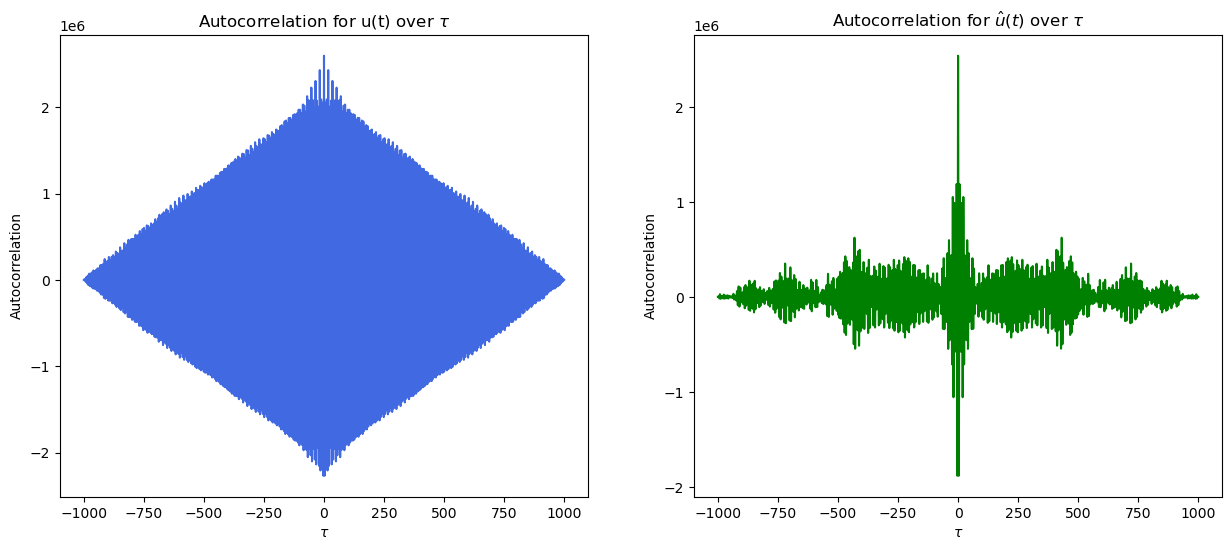

In [ ]:
time = np.linspace(-1000, 1000, 199999)
p = m.plot3D(cols =2, rows = 1, figsize=(15, 6))
p.plot2D(time, np.correlate(A0[0, :], A0[0, :], mode='full'), plotNum=1, title = "Autocorrelation for u(t) over "+r'$\tau$', axlab=[r'$\tau$', "Autocorrelation"])
p.plot2D(time, np.correlate(rc1.uPrediction[0, :], rc1.uPrediction[0, :], mode='full'), plotNum=2, title = "Autocorrelation for "+ r'$\hat u(t)$' +" over "+r'$\tau$', axlab=[r'$\tau$', "Autocorrelation"])
